In [1]:
import os
import csv
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as pl
import statsmodels.api as sm
import re
import pysal
import StringIO
from scipy import stats
from scipy.signal import argrelextrema

%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#!wget https://github.com/fedhere/PUI2016_fb55/blob/master/HW9_fb55/MTA_Fare.npy
!wget https://github.com/fedhere/PUI2016_fb55/blob/master/HW9_fb55/MTA_Fare.npy?raw=true

--2016-11-17 23:31:05--  https://github.com/fedhere/PUI2016_fb55/blob/master/HW9_fb55/MTA_Fare.npy?raw=true
Resolving github.com... 192.30.253.112, 192.30.253.113
Connecting to github.com|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy [following]
--2016-11-17 23:31:05--  https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy
Connecting to github.com|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW9_fb55/MTA_Fare.npy [following]
--2016-11-17 23:31:05--  https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW9_fb55/MTA_Fare.npy
Resolving raw.githubusercontent.com... 151.101.20.133
Connecting to raw.githubusercontent.com|151.101.20.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10708880 (10M) [application/

In [3]:
mtarides = np.load('MTA_Fare.npy?raw=true', mmap_mode='r')
mtarides

memmap([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,

In [4]:
len(mtarides)

600

In [5]:
mtarides.shape

(600, 23, 194)

In [ ]:
'''
Remove & Replace Nan Values
'''

In [7]:
#Make empty ndarray with dtype: float
data_rides = np.empty(mtarides.shape, dtype='float')

In [8]:
#Convert mtarides into float array and storm them as data.
for index, arr in enumerate(mtarides):
    data_rides[index] = arr.astype('float')

In [9]:
#Replace all -1 values with nan.
for arr in data_rides:
    arr[arr == -1] = np.nan

In [ ]:
'''
TASK 1: Search for major events
'''

In [11]:
#Sum over different card types and stations to get overall ridership by week.
cards_sum = np.nansum(data_rides, axis=1)
cards_station = np.nansum(cards_sum, axis=0)

In [12]:
#Look for lowest ridership index.
np.where(cards_station == min(cards_station))

(array([126]),)

In [13]:
#Finds the starting week.
start_date = dt.datetime.strptime('05/21/2010', '%m/%d/%Y')
dweek = dt.timedelta(weeks=127)
print (start_date + dweek)

2012-10-26 00:00:00


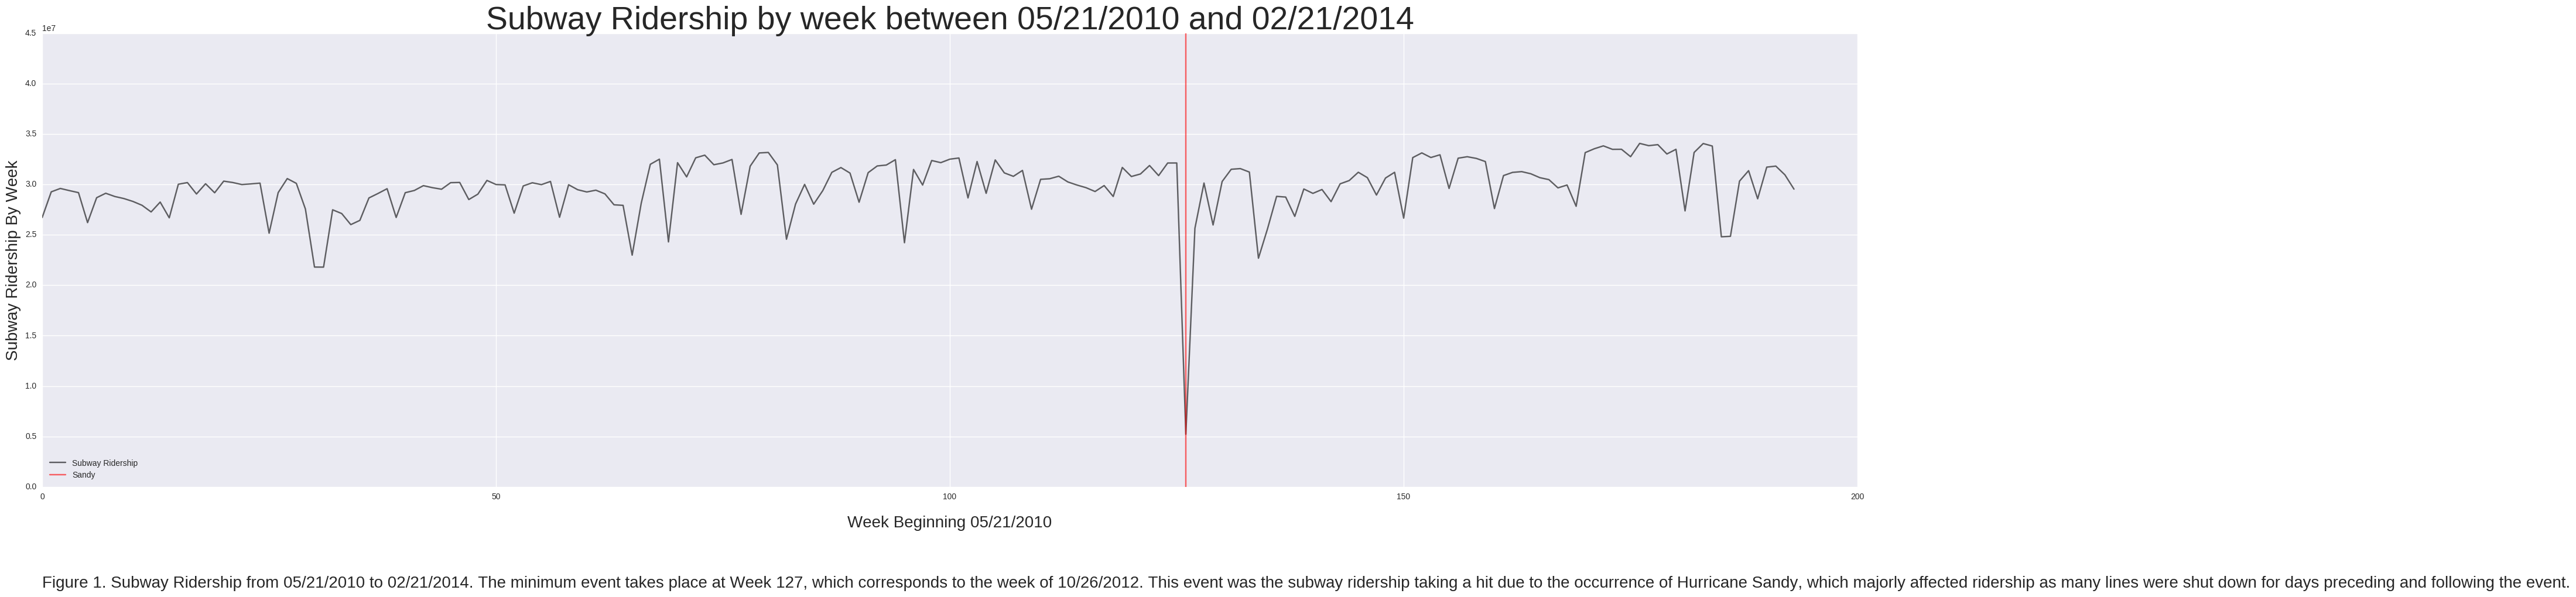

In [14]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(40, 10))
ax.plot(range(cards_station.shape[0]), cards_station, c='k', alpha=0.6, 
        label='Subway Ridership')
ax.plot([126, 126], [0, 45000000], c='r', alpha=0.6, label="Sandy")
ax.set_xlabel('Week Beginning 05/21/2010', fontsize=20, labelpad=18)
ax.set_ylabel('Subway Ridership By Week', fontsize=20)
ax.set_title('Subway Ridership by week between 05/21/2010 and 02/21/2014', fontsize=40)
ax.text(0, -10000000, "Figure 1. Subway Ridership from 05/21/2010 to 02/21/2014. \
The minimum event takes place at Week 127, which corresponds to the week of 10/26/2012. \
This event was the subway ridership taking a hit due to the occurrence of Hurricane Sandy, \
which majorly affected ridership as many lines were shut down for days preceding and following \
the event.", fontsize=20)
ax.legend(loc='lower left', ncol=1)

In [ ]:
'''
TASK 2: Find Change in ridership type
'''

In [16]:
#Summing stations to get each card type ridership by week.
sum_stations = np.nansum(data_rides, axis=0)
sum_stations.shape

(23, 194)

In [17]:
#Loading data to pd dataframe.
card_type = pd.DataFrame(sum_stations)
card_type_T = card_type.T
card_type_T.head()

0         1        2         3        4          5          6   \
0  11494615.0  530524.0  47801.0  186551.0  46808.0  3697443.0  8551937.0   
1  12526859.0  583533.0  51486.0  199229.0  64353.0  3981808.0  9486394.0   
2  12766627.0  586194.0  51636.0  199668.0  56994.0  4033030.0  9476538.0   
3  12653675.0  562602.0  52063.0  196389.0  37429.0  4032753.0  9450081.0   
4  12809694.0  548858.0  51153.0  194883.0  35210.0  3925446.0  9294002.0   

        7         8         9  ...         13        14       15       16  \
0  10063.0  333197.0  512032.0 ...   123134.0  790110.0  59809.0  28221.0   
1  11847.0  282755.0  578023.0 ...   151948.0  908068.0  69209.0  32333.0   
2  12277.0  302028.0  615537.0 ...   151538.0  914124.0  69574.0  32618.0   
3  11221.0  305513.0  606270.0 ...   147094.0  902549.0  68099.0  32404.0   
4  10515.0  335780.0  563446.0 ...   137888.0  855573.0  66377.0  31933.0   

      17        18       19      20     21   22  
0    0.0  124693.0  21060.0  6128.0  358.0  0.0  
1    0.0  121713.0  21670.0  6120.0  474.0  0.0  
2    0.0  122181.0  21433.0  6490.0  465.0  0.0  
3    0.0  122051.0  21630.0  6590.0  484.0  0.0  
4  176.0  119776.0  20297.0  6313.0  452.0  0.0  

[5 rows x 23 columns]

In [18]:
# Return type of card
exc_cards = []
[ exc_cards.append(x) for x in card_type_T.columns for i in card_type_T[x] if i < 1 if x not in exc_cards ]

[None, None, None, None, None, None, None, None]

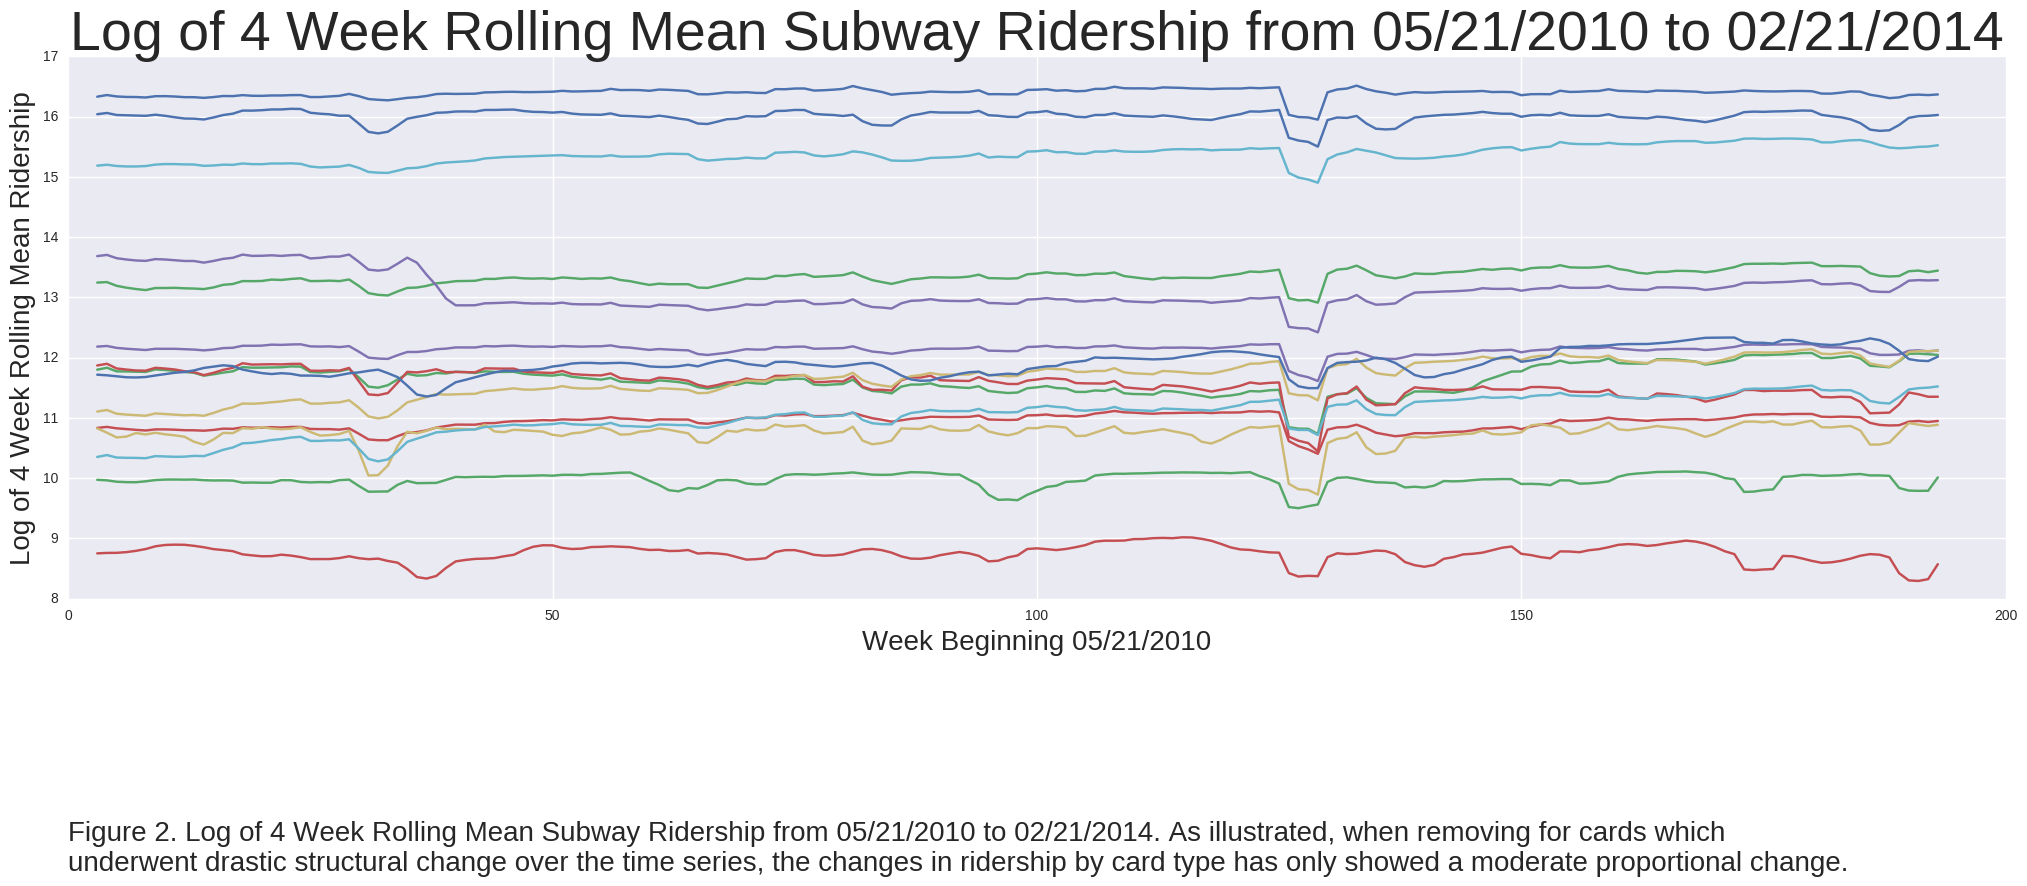

In [19]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(25,7))
for x in card_type_T:
    if x not in exc_cards:
        ax.plot(range(194), np.log(card_type_T[x]).rolling(window=4, center=False).mean())
ax.set_xlabel('Week Beginning 05/21/2010', fontsize=20)
ax.set_ylabel('Log of 4 Week Rolling Mean Ridership', fontsize=20)
ax.set_title('Log of 4 Week Rolling Mean Subway Ridership from 05/21/2010 to 02/21/2014', fontsize=40)
ax.text(0, 3.5, "Figure 2. Log of 4 Week Rolling Mean Subway Ridership \
from 05/21/2010 to 02/21/2014. As illustrated, when removing for cards \
which \nunderwent drastic structural change over the time series, the \
changes in ridership by card type has only showed a moderate proportional \
change.", fontsize=20)

In [20]:
'''
Make boolean list for cards 0-22 that exhibit complex structure, produce list of 
4-week rolling mean for each card, perform linear regression on 4-week ridership
and then finally create list of slopes based on 4-week rolling mean.
'''
complex_1 = []
for i in range(23):
    if i in exc_cards:
        complex_1.append(True)
    else:
        complex_1.append(False)

rm = []
for x in card_type_T.columns:
    rm.append(card_type_T[x].rolling(4).mean().dropna())
    
lr=[]
for x in rm:
    lr.append(np.polyfit(range(191), x, 1))

slope = []
for x in enumerate(lr):
    slope.append(x[1][0])

In [21]:
'''
Calculate fields for beginning and ending 10-week periods and their ratios.
'''
card_sum = pd.DataFrame()
card_sum['Beg10_Sum'] = card_type[range(10)].sum(axis=1)
card_sum['Last10_Sum'] = card_type[range(184, 194)].sum(axis=1)
card_sum['Diff'] = card_sum['Last10_Sum'] - card_sum['Beg10_Sum']
card_sum['Label'] = ['10 Trip', '14 Day', '1 Day', '2 Trip',
                     '30 Day', '7 Day', 'ADA', 'AFAS', 'EXP',
                     'EZPAY', 'FF', 'MC', 'MR', 'Monthly',
                     'RFM', 'RR', 'SEN', 'SPEC', 'TCMC', 'TKT',
                     'UNL', 'XBUS', 'Student']
card_sum['Complex'] = complex_1
card_sum['Slope_4wRM'] = slope
card_sum['Ratio'] = card_sum['Last10_Sum'] / card_sum['Beg10_Sum']
df_sum = card_sum.sort_values('Ratio', axis=0, ascending=True)
df_sum

Beg10_Sum   Last10_Sum        Diff    Label Complex    Slope_4wRM  \
9     5992187.0          9.0  -5992178.0    EZPAY    True  -2544.543263   
8     3274997.0         35.0  -3274962.0      EXP    True  -1253.738544   
7      109813.0         23.0   -109790.0     AFAS    True    -47.737809   
13    1372964.0     794565.0   -578399.0  Monthly   False   -301.865688   
14    8440283.0    5482879.0  -2957404.0      RFM   False  -1173.158671   
20      66263.0      53611.0    -12652.0      UNL   False     -0.757377   
10     412549.0     337796.0    -74753.0       FF    True    -57.097198   
6    91175712.0   82043675.0  -9132037.0      ADA   False  -2378.377331   
3     1906275.0    1780086.0   -126189.0   2 Trip   False    -31.883115   
19     211311.0     215873.0      4562.0      TKT   False      2.564441   
0   123473261.0  126164722.0   2691461.0  10 Trip   False   3865.940212   
4      479562.0     495765.0     16203.0   30 Day   False     16.600933   
2      498989.0     554549.0     55560.0    1 Day   False     35.649849   
11    1318897.0    1600535.0    281638.0       MC   False    129.304715   
1     5333762.0    6678217.0   1344455.0   14 Day   False   1059.505695   
5    39343036.0   54676890.0  15333854.0    7 Day   False  10301.200573   
18    1208606.0    1851912.0    643306.0     TCMC   False    445.296472   
21       4762.0       7916.0      3154.0     XBUS    True      3.714443   
15     645160.0    1672874.0   1027714.0       RR   False    610.970102   
16     312086.0     907982.0    595896.0      SEN   False    333.799512   
17       4540.0     318628.0    314088.0     SPEC    True    148.932728   
12         58.0    1437526.0   1437468.0       MR    True    862.115176   
22          0.0   10685396.0  10685396.0  Student    True   4726.395445   

           Ratio  
9   1.501956e-06  
8   1.068703e-05  
7   2.094470e-04  
13  5.787224e-01  
14  6.496084e-01  
20  8.090639e-01  
10  8.188021e-01  
6   8.998413e-01  
3   9.338034e-01  
19  1.021589e+00  
0   1.021798e+00  
4   1.033787e+00  
2   1.111345e+00  
11  1.213541e+00  
1   1.252065e+00  
5   1.389748e+00  
18  1.532271e+00  
21  1.662327e+00  
15  2.592960e+00  
16  2.909397e+00  
17  7.018238e+01  
12  2.478493e+04  
22           inf

In [22]:
cardtypecount = df_sum['Label'].unique()
cardtypecomp = df_sum[df_sum.Complex != True]
cardtypecomp.count()

Beg10_Sum     15
Last10_Sum    15
Diff          15
Label         15
Complex       15
Slope_4wRM    15
Ratio         15
dtype: int64

In [23]:
cardtypecomp = cardtypecomp.sort_values(['Slope_4wRM'], ascending=[0])
cardtypecomp

Beg10_Sum   Last10_Sum        Diff    Label Complex    Slope_4wRM  \
5    39343036.0   54676890.0  15333854.0    7 Day   False  10301.200573   
0   123473261.0  126164722.0   2691461.0  10 Trip   False   3865.940212   
1     5333762.0    6678217.0   1344455.0   14 Day   False   1059.505695   
15     645160.0    1672874.0   1027714.0       RR   False    610.970102   
18    1208606.0    1851912.0    643306.0     TCMC   False    445.296472   
16     312086.0     907982.0    595896.0      SEN   False    333.799512   
11    1318897.0    1600535.0    281638.0       MC   False    129.304715   
2      498989.0     554549.0     55560.0    1 Day   False     35.649849   
4      479562.0     495765.0     16203.0   30 Day   False     16.600933   
19     211311.0     215873.0      4562.0      TKT   False      2.564441   
20      66263.0      53611.0    -12652.0      UNL   False     -0.757377   
3     1906275.0    1780086.0   -126189.0   2 Trip   False    -31.883115   
13    1372964.0     794565.0   -578399.0  Monthly   False   -301.865688   
14    8440283.0    5482879.0  -2957404.0      RFM   False  -1173.158671   
6    91175712.0   82043675.0  -9132037.0      ADA   False  -2378.377331   

       Ratio  
5   1.389748  
0   1.021798  
1   1.252065  
15  2.592960  
18  1.532271  
16  2.909397  
11  1.213541  
2   1.111345  
4   1.033787  
19  1.021589  
20  0.809064  
3   0.933803  
13  0.578722  
14  0.649608  
6   0.899841

In [24]:
'''
It turns out there are eight card types with complex structure.

Then the five card types with the highest proportional increase
in use (without complex structure) were:

- Senior Citizen/Disabled
- Transit Check Metrocard
- Railroad
- 7 day
- 14 day

While the five with the highest proportional decrease in use were:

- Unlimited
- Monthly
- 2 trip
- RFM
- ADA

'''

'\nIt turns out there are eight card types with complex structure.\n\nThen the five card types with the highest proportional increase\nin use (without complex structure) were:\n\n- Senior Citizen/Disabled\n- Transit Check Metrocard\n- Railroad\n- 7 day\n- 14 day\n\nWhile the five with the highest proportional decrease in use were:\n\n- Unlimited\n- Monthly\n- 2 trip\n- RFM\n- ADA\n\n'

In [ ]:
'''
TASK 3: Find Periodicity
'''

In [26]:
df_3 = pd.DataFrame(cards_sum)
df_3 = df_3.T

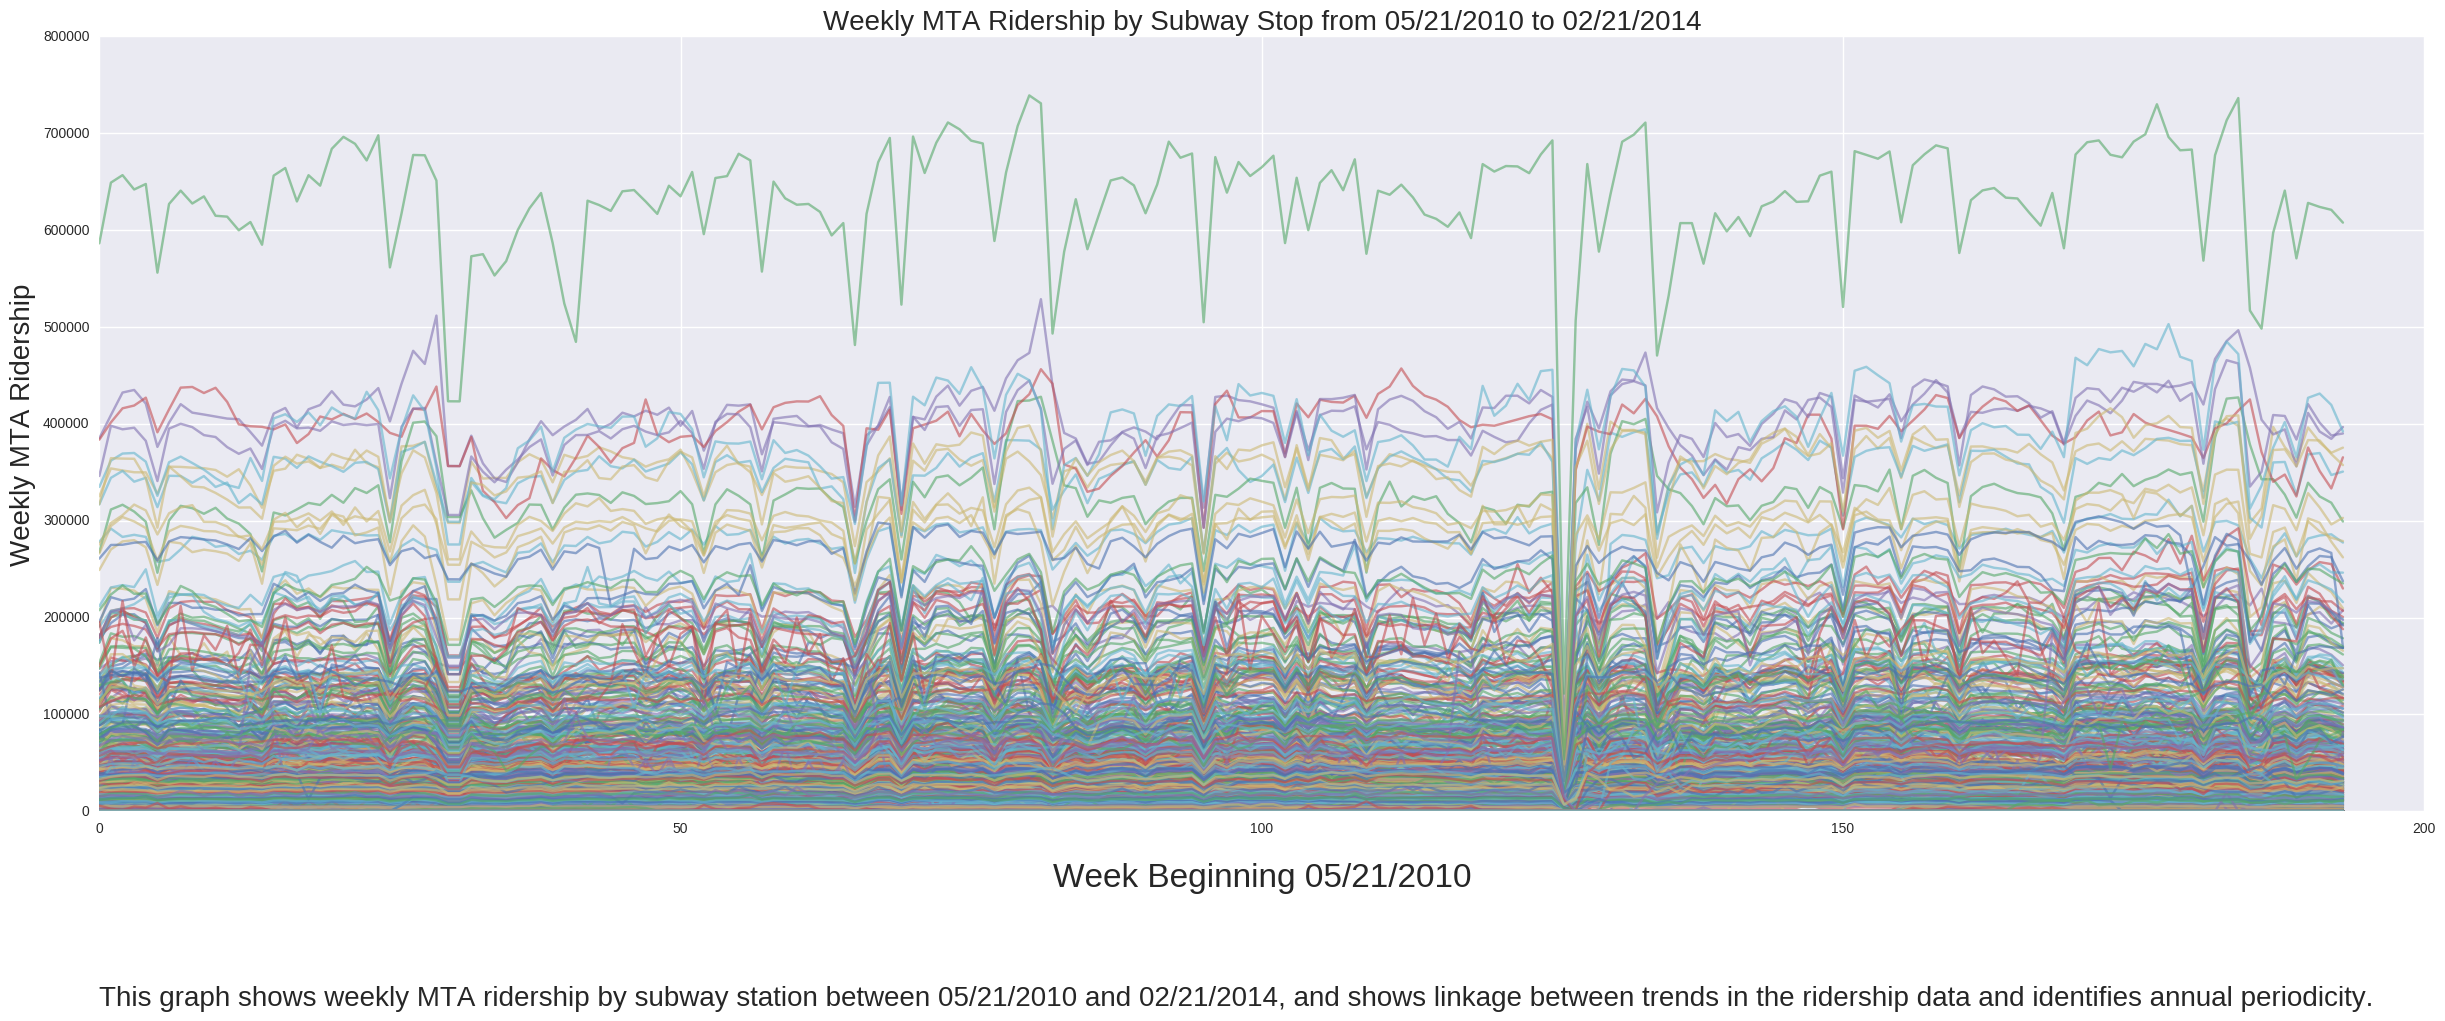

In [27]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(30, 10))
for x in df_3.columns:
    ax.plot(range(194), df_3[x], alpha=0.6, label="MTA Ridership")
ax.set_xlabel('Week Beginning 05/21/2010', fontsize=24, labelpad=20)
ax.set_ylabel('Weekly MTA Ridership', fontsize=20)
ax.set_title('Weekly MTA Ridership by Subway Stop from 05/21/2010 to 02/21/2014', fontsize=20)
ax.text(0, -200000, "This graph shows weekly MTA ridership by subway station between 05/21/2010 and 02/21/2014, and shows \
linkage between trends in the ridership data and identifies annual periodicity.", fontsize=20)

In [28]:
#Append fourier transformation of each column to a list
f_trans = []
for x in df_3.columns:
    f_trans.append(np.abs(np.fft.rfft(df_3[x])))
np.fft.rfftfreq(194)[2:].shape == f_trans[0][2:].shape

True

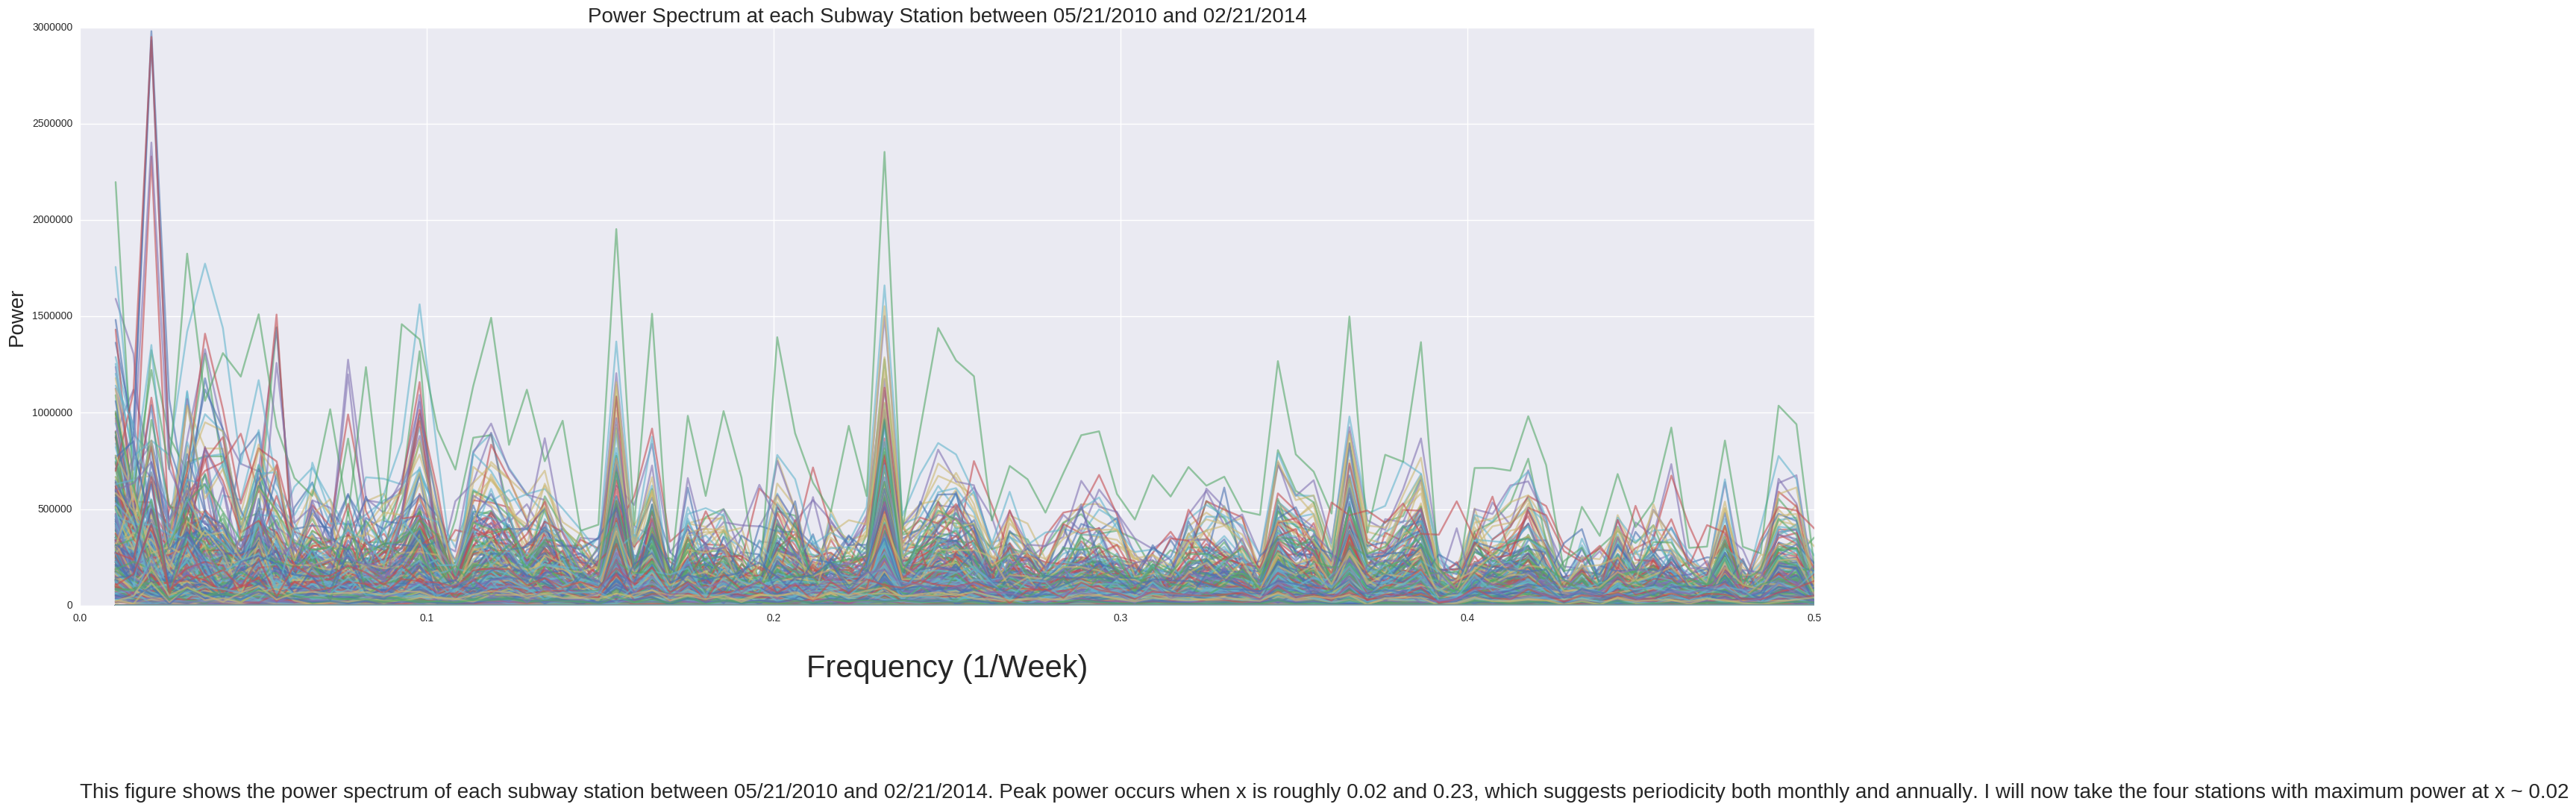

In [29]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(30,10))
for x in f_trans:
    ax.plot(np.fft.rfftfreq(194)[2:], x[2:], alpha=0.6, label="MTA Ridership")
ax.set_xlabel('Frequency (1/Week)', fontsize=30, labelpad=30)
ax.set_ylabel('Power', fontsize=20)
ax.set_title('Power Spectrum at each Subway Station between 05/21/2010 and 02/21/2014', fontsize=20)
ax.text(0, -1000000, "This figure shows the power spectrum of each subway station \
between 05/21/2010 and 02/21/2014. Peak power occurs when x is roughly 0.02 and 0.23, which suggests periodicity both monthly and annually. I will now take the four stations \
with maximum power at x ~ 0.02", fontsize=20)

In [30]:
'''
Append annual power values to a list, then enumerate annual values from \
the list and finally sort the enumerated list values by the second value \
in the tuple.
'''
yrly = []
for y in f_trans:
    yrly.append(y[4])
    
enum_yrly = []
for tup in enumerate(yrly):
    enum_yrly.append(tup)
    
enum_yrly.sort(key=lambda tup: tup[1], reverse=True)

In [31]:
#Extract the highest 4 values for annual periodicity.
enum_yrly[0:4]

[(0, 2980160.6355953491),
 (194, 2950388.929214194),
 (150, 2931895.8769513383),
 (327, 2402218.5809588572)]

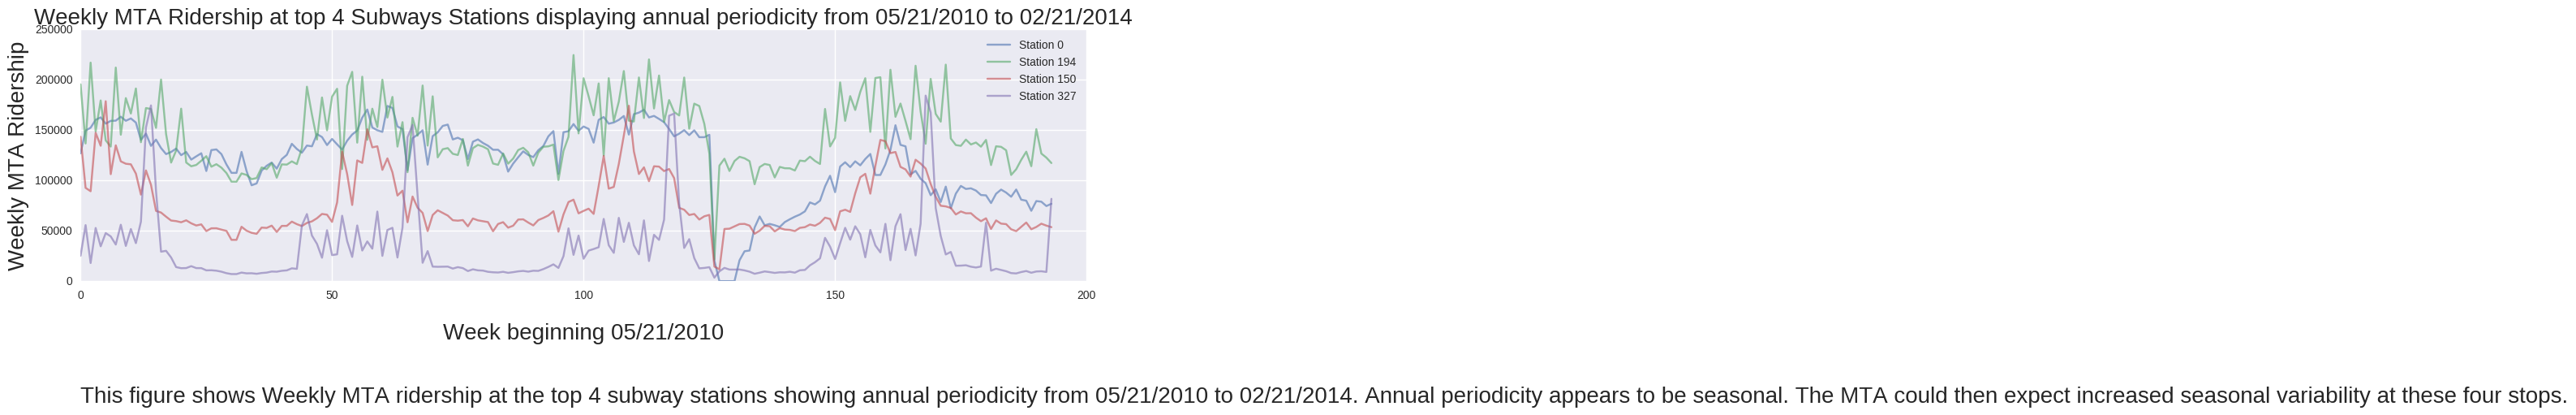

In [32]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))
for x in [0, 194, 150, 327]:
    ax.plot(range(194), df_3[x], alpha=0.6, zorder=2, label='Station ' + str(x))
ax.set_xlabel('Week beginning 05/21/2010', fontsize=20, labelpad=20)
ax.set_ylabel('Weekly MTA Ridership', fontsize=20)
ax.set_title('Weekly MTA Ridership at top 4 Subways Stations displaying annual \
periodicity from 05/21/2010 to 02/21/2014', fontsize=20)
ax.text(0, -120000, "This figure shows Weekly MTA ridership at the top 4 \
subway stations showing annual periodicity from 05/21/2010 to 02/21/2014. \
Annual periodicity appears to be seasonal. The MTA could then expect \
increased seasonal variability at these four stops.", fontsize=20)
ax.legend(loc='upper right')